In [1]:
import numpy as np
import pandas as pd

# import GPUtil
# #imports from python 3.8
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimgZ
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential, Model
from scipy.stats import skew
from joblib import dump, load


In [2]:
import subprocess

def get_gpu_details():
    try:
        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output = result.stdout.decode('utf-8')
        print(output)
    except FileNotFoundError:
        print("nvidia-smi not found. Please make sure NVIDIA drivers are installed.")

# Call the function to display GPU details
get_gpu_details()


Fri May 10 16:38:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0              18W /  55W |    229MiB /  4096MiB |     20%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# import torch
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print("Device: ",device)
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # export CUDA_VISIBLE_DEVICES=0
# GPUtil.getAvailable()
# use_cuda = torch.cuda.is_available()
# if use_cuda:
#     print('__CUDNN VERSION:', torch.backends.cudnn.version())
#     print('__Number CUDA Devices:', torch.cuda.device_count())
#     print('__CUDA Device Name:',torch.cuda.get_device_name(0))
#     print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
# else:
#     print("None")


print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import sys
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print(sys.version)
tf.test.is_gpu_available()

Tensorflow version: 2.10.0
3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
df = pd.read_csv('./data/df_final.csv')

X_train = pd.read_csv('./data/X_train_final.csv')
Y_train = pd.read_csv('./data/Y_train_final.csv')
X_test = pd.read_csv('./data/X_test.csv')
Y_test = pd.read_csv('./data/Y_test.csv')
X_val = pd.read_csv('./data/X_val.csv')
Y_val = pd.read_csv('./data/Y_val.csv')

### HYPERPARAMETER

In [7]:
# Model Parameters
BATCH_SIZE = 32
INPUT_DIM = (150, 150, 3)  # RGB - 3 channels images
OUTPUT_CLASSES = 6  # One-hot encoded: 8 different classes

# Training Parameters
EPOCHS = 32
LEARNING_RATE = 1e-2

## Model Training

In [8]:
Y_val['Class'] = Y_val['Class'].astype(str)
merged_val_df = pd.concat([X_val, Y_val], axis=1)
merged_train_df = pd.concat([X_train, Y_train], axis=1)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                       height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest',
                               vertical_flip=False,
                               validation_split=0.3)

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
# )

val_datagen = ImageDataGenerator(rescale=1./255)


# Flow from merged DataFrame with full image paths
train_generator = train_datagen.flow_from_dataframe(
    dataframe=merged_train_df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42,
)

# Flow from merged DataFrame with full image paths
val_generator = val_datagen.flow_from_dataframe(
    dataframe=merged_val_df,
    # directory= df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 47999 validated image filenames belonging to 6 classes.


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="ImgPath". These filename(s) will be ignored.
  warnings.warn(


Found 16267 validated image filenames belonging to 6 classes.


In [9]:
X_test = pd.read_csv('./data/X_test.csv')
Y_test = pd.read_csv('./data/Y_test.csv')
merged_test_df = pd.concat([X_test, Y_test], axis=1)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=merged_test_df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    seed=42
)

Found 16267 validated image filenames belonging to 6 classes.


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras import regularizers

model_name = 'My_ANN_Model'  # Give a name to your model
HIDDEN_LAYER_DIM5 = 512
HIDDEN_LAYER_DIM4 = 256
HIDDEN_LAYER_DIM3 = 128
HIDDEN_LAYER_DIM2 = 64
HIDDEN_LAYER_DIM1 = 32
with tf.device('GPU:0'):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),  # Flatten the (150, 150, 3) images to 1D vectors
        tf.keras.layers.Dense(8, activation='relu'),  # First hidden layer
        tf.keras.layers.Dense(32, activation='relu'),  # First hidden layer
        tf.keras.layers.Dense(64, activation='relu'),  # Second hidden layer
        tf.keras.layers.Dense(64, activation='relu'),  # Third hidden layer
        tf.keras.layers.Flatten(),  # Third hidden layer
        tf.keras.layers.Dense(128, activation='relu'),  # Fourth hidden layer
        tf.keras.layers.Dense(64, activation='relu'),  # Second hidden layer
        tf.keras.layers.Dense(32, activation='relu'),  # Second hidden layer
        # tf.keras.layers.Dropout(0.5),  # Dropout to reduce overfitting
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),  # Output layer with softmax activation
    ], name=model_name)
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Train the model
log_dir = "./Model/log_model_ANN/"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model.fit(
        train_generator,
        steps_per_epoch=100,  # depends on the size of your training set
        epochs=30,
        validation_data=val_generator,
        validation_steps=50)  # depends on the size of your validation set

# Save the model
model.save('modelANN1.h5')

Epoch 1/30
100/100 [==============================] - 29s 291ms/step - loss: 1.8129 - accuracy: 0.1688 - val_loss: 1.7979 - val_accuracy: 0.0744
Epoch 2/30
100/100 [==============================] - 31s 306ms/step - loss: 1.7921 - accuracy: 0.1700 - val_loss: 1.7976 - val_accuracy: 0.0944
Epoch 3/30
100/100 [==============================] - 30s 303ms/step - loss: 1.7918 - accuracy: 0.1594 - val_loss: 1.7971 - val_accuracy: 0.1025
Epoch 4/30
100/100 [==============================] - 27s 275ms/step - loss: 1.7916 - accuracy: 0.1700 - val_loss: 1.7973 - val_accuracy: 0.0781
Epoch 5/30
100/100 [==============================] - 27s 269ms/step - loss: 1.7917 - accuracy: 0.1847 - val_loss: 1.8044 - val_accuracy: 0.0712
Epoch 6/30
100/100 [==============================] - 31s 308ms/step - loss: 1.7922 - accuracy: 0.1685 - val_loss: 1.7952 - val_accuracy: 0.0787
Epoch 7/30
100/100 [==============================] - 34s 342ms/step - loss: 1.7921 - accuracy: 0.1734 - val_loss: 1.7962 - val_ac

KeyboardInterrupt: 

## ResNet50

In [22]:
Y_val['Class'] = Y_val['Class'].astype(str)
merged_val_df = pd.concat([X_val, Y_val], axis=1)
merged_train_df = pd.concat([X_train, Y_train], axis=1)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                       height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest',
                               vertical_flip=False,
                               validation_split=0.3)

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
# )

val_datagen = ImageDataGenerator(rescale=1./255)


# Flow from merged DataFrame with full image paths
train_generator = train_datagen.flow_from_dataframe(
    dataframe=merged_train_df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42,
)

# Flow from merged DataFrame with full image paths
val_generator = val_datagen.flow_from_dataframe(
    dataframe=merged_val_df,
    # directory= df,
    x_col='ImgPath',
    y_col='Class',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 47999 validated image filenames belonging to 6 classes.


C:\Users\LENOVO\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="ImgPath". These filename(s) will be ignored.
  warnings.warn(


Found 16267 validated image filenames belonging to 6 classes.


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 base model, pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top for our specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(6, activation='softmax')(x)  # Add a logistic layer for 6 classes

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show the model structure
model.summary()


94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Train the model
log_dir = "./Model/log_model_ResNet50/"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model.fit(
        train_generator,
        steps_per_epoch=100,  # depends on the size of your training set
        epochs=30,
        validation_data=val_generator,
        validation_steps=50)  # depends on the size of your validation set

# Save the model
model.save('modelResNet50.h5')

Epoch 1/30
100/100 [==============================] - 60s 520ms/step - loss: 1.7419 - accuracy: 0.2722 - val_loss: 1.8811 - val_accuracy: 0.2469
Epoch 2/30
100/100 [==============================] - 52s 523ms/step - loss: 1.6261 - accuracy: 0.3212 - val_loss: 1.5786 - val_accuracy: 0.2881
Epoch 3/30
100/100 [==============================] - 53s 531ms/step - loss: 1.5512 - accuracy: 0.3800 - val_loss: 1.3303 - val_accuracy: 0.5312
Epoch 4/30
100/100 [==============================] - 54s 538ms/step - loss: 1.5320 - accuracy: 0.3647 - val_loss: 1.3074 - val_accuracy: 0.4706
Epoch 5/30
100/100 [==============================] - 56s 558ms/step - loss: 1.5502 - accuracy: 0.3522 - val_loss: 1.3328 - val_accuracy: 0.4963
Epoch 6/30
100/100 [==============================] - 53s 533ms/step - loss: 1.4970 - accuracy: 0.4019 - val_loss: 1.3783 - val_accuracy: 0.4981
Epoch 7/30
100/100 [==============================] - 54s 537ms/step - loss: 1.5020 - accuracy: 0.4019 - val_loss: 1.3188 - val_ac

In [26]:
# Save history
dump(history.history, 'history_modelResNet50.pkl')

['history_modelResNet50.pkl']

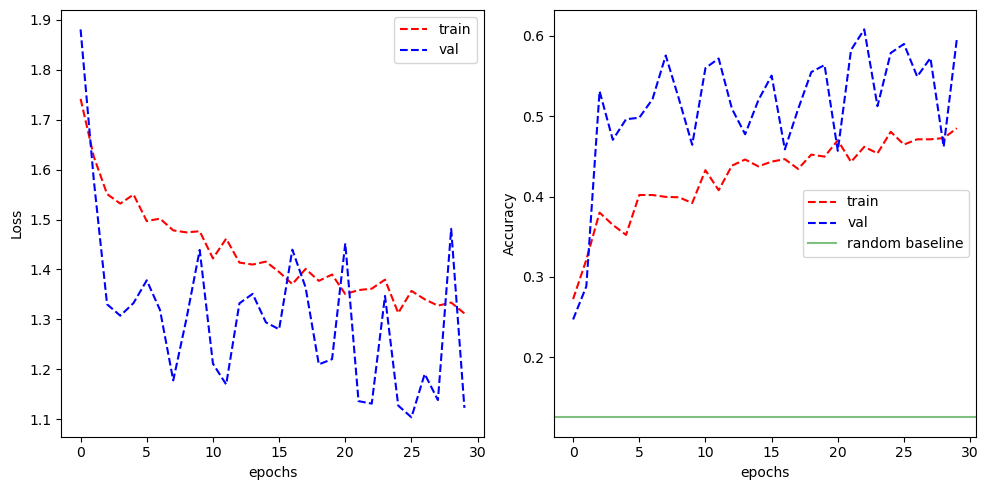

In [28]:
# Load history
history = load('history_modelResNet50.pkl')
plot_name = 'clf-resnet50'
plot_learning_curve(
    history['loss'],
    history['val_loss'],
    history['accuracy'],
    history['val_accuracy'],
    to_file=f'images/{plot_name}-LearningCurve.png'
)

In [27]:
def plot_learning_curve(
        train_loss, val_loss, train_metric, val_metric,
        to_file: str = None
) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(train_loss, 'r--')
    ax[0].plot(val_loss, 'b--')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend(['train', 'val'])

    ax[1].plot(train_metric, 'r--')
    ax[1].plot(val_metric, 'b--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].axhline(y=0.125, c='g', alpha=0.5)  # Random probability - naive classifier
    ax[1].legend(['train', 'val', 'random baseline'])

    fig.tight_layout()
    plt.show()
    if to_file is not None:
        fig.savefig(to_file)

In [48]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_DIM)
cnt = 0
for layer in resnet_50.layers:
    if cnt < 2:
        layer.trainableain = True
    else:    
        layer.trainable = False
    cnt += 1

In [49]:
###### build the entire model
x = resnet_50.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
predictions = Dense(6, activation='softmax')(x)  # Add a logistic layer for 6 classes
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(6, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [52]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)  # Adjust the number of units to match the number of classes

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some of the top layers of the model
for layer in base_model.layers[-20:]:  # Unfreezing the last 20 layers
    layer.trainable = True

# Recompile the model (necessary after making any changes to the 'trainable' property of any layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [53]:
log_dir = "./Model/log_model_ResNet50-2/"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model.fit(
        train_generator,
        steps_per_epoch=100,  # depends on the size of your training set
        epochs=30,
        validation_data=val_generator,
        validation_steps=50)  # depends on the size of your validation set
    
# Save the model
model.save('modelResNet2.h5')

Epoch 1/30
100/100 [==============================] - 57s 530ms/step - loss: 1.5181 - accuracy: 0.3800 - val_loss: 1.7413 - val_accuracy: 0.0812
Epoch 2/30
100/100 [==============================] - 52s 522ms/step - loss: 1.2900 - accuracy: 0.4816 - val_loss: 1.4732 - val_accuracy: 0.2981
Epoch 3/30
100/100 [==============================] - 52s 514ms/step - loss: 1.2083 - accuracy: 0.5294 - val_loss: 1.3840 - val_accuracy: 0.4475
Epoch 4/30
100/100 [==============================] - 51s 513ms/step - loss: 1.1659 - accuracy: 0.5474 - val_loss: 0.9052 - val_accuracy: 0.6575
Epoch 5/30
100/100 [==============================] - 51s 508ms/step - loss: 1.1481 - accuracy: 0.5653 - val_loss: 0.9760 - val_accuracy: 0.6706
Epoch 6/30
100/100 [==============================] - 51s 512ms/step - loss: 1.1120 - accuracy: 0.5758 - val_loss: 0.9651 - val_accuracy: 0.6344
Epoch 7/30
100/100 [==============================] - 50s 503ms/step - loss: 1.0896 - accuracy: 0.5775 - val_loss: 0.8770 - val_ac

In [54]:
# Save history
dump(history.history, 'history_modelResNet50-2.pkl')

['history_modelResNet50-2.pkl']

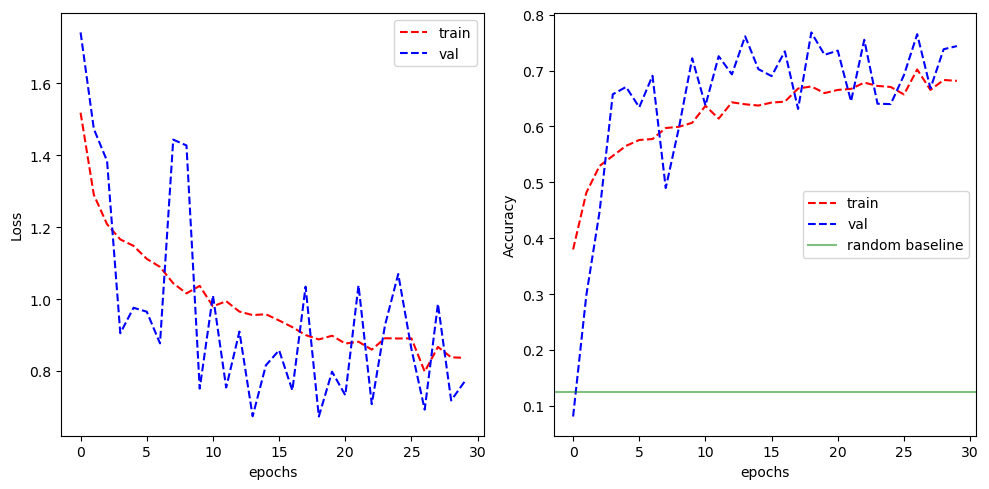

In [62]:
# Load history
history = load('history_modelResNet50-2.pkl')
plot_name = 'clf-resnet50'
plot_learning_curve(
    history['loss'],
    history['val_loss'],
    history['accuracy'],
    history['val_accuracy'],
    to_file=f'images/{plot_name}-LearningCurve.png'
)

In [56]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)  # Adjust the number of units to match the number of classes

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some of the top layers of the model
for layer in base_model.layers[-20:]:  # Unfreezing the last 20 layers
    layer.trainable = True

# Recompile the model (necessary after making any changes to the 'trainable' property of any layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [59]:
log_dir = "./Model/log_model_ResNet50-3/"
with tf.device('GPU:0'):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)
    history = model.fit(
        train_generator,
        epochs=35,
        steps_per_epoch= 500,
        validation_data=val_generator,
        ) 
    
# Save the model
model.save('modelResNet3.h5')

Epoch 1/35
500/500 [==============================] - 304s 608ms/step - loss: 1.2618 - accuracy: 0.4776 - val_loss: 1.4778 - val_accuracy: 0.4480
Epoch 2/35
500/500 [==============================] - 306s 612ms/step - loss: 1.1732 - accuracy: 0.5387 - val_loss: 0.9477 - val_accuracy: 0.6472
Epoch 3/35
500/500 [==============================] - 307s 614ms/step - loss: 1.0963 - accuracy: 0.5704 - val_loss: 1.1315 - val_accuracy: 0.5964
Epoch 4/35
500/500 [==============================] - 302s 604ms/step - loss: 1.0332 - accuracy: 0.6042 - val_loss: 1.4521 - val_accuracy: 0.5508
Epoch 5/35
500/500 [==============================] - 302s 604ms/step - loss: 0.9922 - accuracy: 0.6263 - val_loss: 1.0720 - val_accuracy: 0.5953
Epoch 6/35
500/500 [==============================] - 301s 602ms/step - loss: 0.9570 - accuracy: 0.6364 - val_loss: 1.0693 - val_accuracy: 0.6529
Epoch 7/35
500/500 [==============================] - 299s 597ms/step - loss: 0.9216 - accuracy: 0.6502 - val_loss: 0.9628 -

In [60]:
# Save history
dump(history.history, 'history_modelResNet50-3.pkl')

['history_modelResNet50-3.pkl']

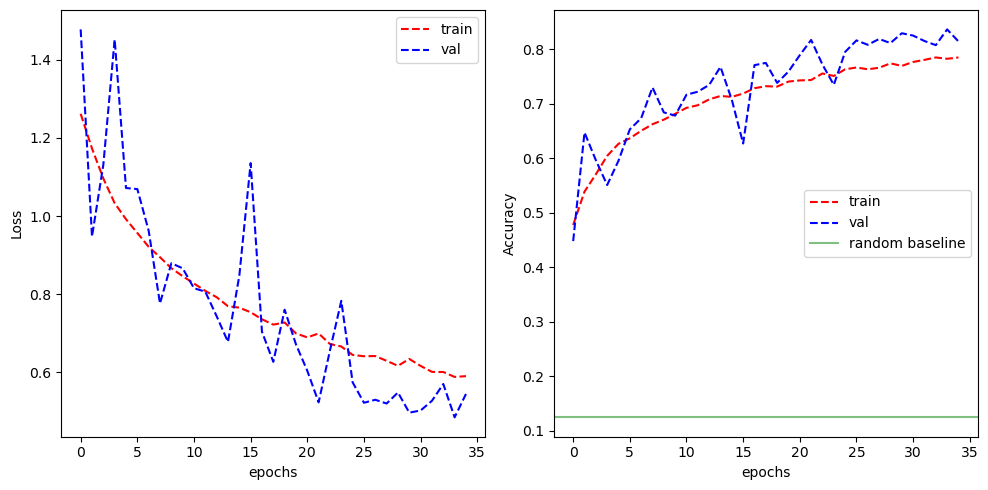

In [61]:
# Load history
history = load('history_modelResNet50-3.pkl')
plot_name = 'clf-resnet50'
plot_learning_curve(
    history['loss'],
    history['val_loss'],
    history['accuracy'],
    history['val_accuracy'],
    to_file=f'images/{plot_name}-LearningCurve.png'
)